# System's agreement and reliabilitty

This section evaluates the agreement and reliability of the developed system on its two configurations (`C1` and `C2`) compared with a reference (manual) method. In addition, the performance of both system configurations is also compared.

::: {.callout-warning}
## Plotly loading issue
This page contains Plotly interactive figures. Sometimes, the figures might not load properly and show a blank image. **Reloading the page might solve the loading issue**.
:::

In [1]:
from libs.chapter4.analysis.data_loading import load_subjects_info, load_experiment_results
from libs.chapter4.analysis.statistical_tests import compare_rmse_distributions, compute_icc
from libs.chapter4.analysis.tug_results_processing import invalidate_executions, check_status, compute_errors_by_subject, PHASES
from libs.chapter4.analysis.visualization import error_distribution, bland_altman_plot

from itables import show

subjects_info, age_info, gender_info = load_subjects_info()
c1_results, c2_results, man_results = load_experiment_results()

/opt/homebrew/Caskroom/miniforge/base/envs/tf310/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Subjects information

@tbl-subjects_info contains information (i.e., age, gender, number of TUG executions) regarding the participants in the evaluation of the system.

In [2]:
#| label: tbl-subjects_info
#| tbl-cap: "Information of the participants in the evaluation."

show(subjects_info)
print(age_info)
print(gender_info)

Age info: min=21.00, max=73.00, mean=43.77, std=14.08
Gender info: male=16 (53.333333333333336), female=14 (46.666666666666664)


## Analysis

### TUG results preparation

In some ocassions, although the systems are able to obtain valid results, the way these results are obtained is incorrect. For instance, the system might not be able to correctly detect when the subject has sit down (due to trousers/pocket characteristics), but ending up detecting the end of the test after the subject extracts the smartphone from the pocket and generating apparently valid results. Therefore, these results are not valid and must be marked as invalid. Following, these cases are reported:

- s10: all the results from the **smartphone** (`C2`) are invalid. The pocket of the subject was small, with half of the smartphone being outside it. When the subject sat down, the smartphone was in a position that the system was not able to recognize as `SEATED`.
- s11: the $4^{th}$ result from the **smartphone** (`C2`) is invalid. The subject wore pants with loose pockets, and in the $4^{th}$ execution was not able to detect the subject as being `SEATED`.
- s25: the $3^{rd}$ and $5^{th}$ results from the **smartphone** (`C2`) are invalid. The pocket of the subject was small, with half of the smartphone being outside it. When the subject sat down, the smartphone was in a position that the system was not able to recognize as `SEATED`.

Next, these cases are manually modified in order to invalidate them (i.e., setting their duration to -1).

In [3]:
invalid_c2 = {
    's10': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    's11': [4],
    's25': [3, 5]
}

c2_results = invalidate_executions(c2_results, invalid_c2)

### Analysis of errors

Each results is classified depending on the information that the systems were able to obtain:

- **success**: the system was able to compute the total duration of the test and the duration of every subphase.
- **partial_success** the was system was able to compute the total duration of the test, but failed to compute the duration of any of the subphases.
- **failure**: the system was not able to compute the total duration of the test.

In [4]:
print('Analyzing C1 (smartwatch) results')
c1_results['status'] = c1_results.apply(check_status, axis=1)

print('Analyzing C2 (smartphone) results')
c2_results['status'] = c2_results.apply(check_status, axis=1)

errors_df = compute_errors_by_subject({ 'C1': c1_results, 'C2': c2_results }, man_results)

Analyzing C1 (smartwatch) results
Found partial success: 19
Found partial success: 23
Found partial success: 24
Found partial success: 26
Found failure: 41
Found failure: 43
Found partial success: 80
Found failure: 81
Found partial success: 84
Found failure: 104
Found partial success: 110
Found partial success: 155
Found partial success: 163
Found partial success: 164
Found partial success: 192
Found failure: 201
Found partial success: 207
Found partial success: 209
Found partial success: 243
Found partial success: 244
Found partial success: 248
Found failure: 275
Analyzing C2 (smartphone) results
Found failure: 10
Found failure: 11
Found failure: 14
Found failure: 16
Found failure: 18
Found failure: 43
Found failure: 55
Found failure: 89
Found failure: 90
Found failure: 91
Found failure: 92
Found failure: 93
Found failure: 94
Found failure: 95
Found failure: 96
Found failure: 97
Found failure: 98
Found failure: 102
Found failure: 112
Found partial success: 120
Found failure: 130
Found

@tbl-executions_classified shows the **success**, **partial success** and **failure** results classification. `C1` obtained a higher **success** and **partial success** rate than `C2` ($92.44\%$ and $5.5\%$ vs. $81.1\%$ and $2.41\%$). Regarding **failures**, `C1` obtained a better rate than `C2` ($2.06\%$ vs $16.49\%$).

A deeper analysis of the **failures** showed that male participants were responsible for $5$ out of the $6$ **failures** in `C1`, where the system failed to recognize the **standing_up** subphase. On the other hand, female participants were responsible for $39$ out of the $48$ **failures** in `C2`, mainly due to wearing jeans with small pockets that placed the smartphone in an un-favourable position, which significantly affected the recognition of the **sitting_down** subphase.

In [5]:
#| label: tbl-executions_classified
#| tbl-cap: "Classified results obtained by the system in both configurations."

execution_status = errors_df[['system', 'status']].groupby('system').value_counts().to_frame('counts').reset_index(level=1).pivot(columns='status', values='counts')
execution_status

status  failure  partial_success  success
system                                   
C1            6               16      269
C2           48                7      236

@fig-error_distribution shows the distribution of the measurement error (i.e., *system_measure* $-$ *manual_measure*) for the total duration (i.e., *duration*) of the test and each subphase (i.e., *standing_up*, *first_walk*, *first_turn*, *second_walk*, *second_turn* and *sitting_down*) for the executions classified as *success*. In addition, the mean of the distribution of each measurement is compared to $0$ with a T-test or a W-test. Results indicate that the mean of the measurement errors of *standing_up* and *sitting_down* are not significantly different from $0$ in both configurations, neither are the errors of *first_turn* and *duration* in `C1` and `C2`, respectively. These results indicate that, on average, the system provides very accurate measurements for the mentioned metrics and configurations compared with the reference measurements.

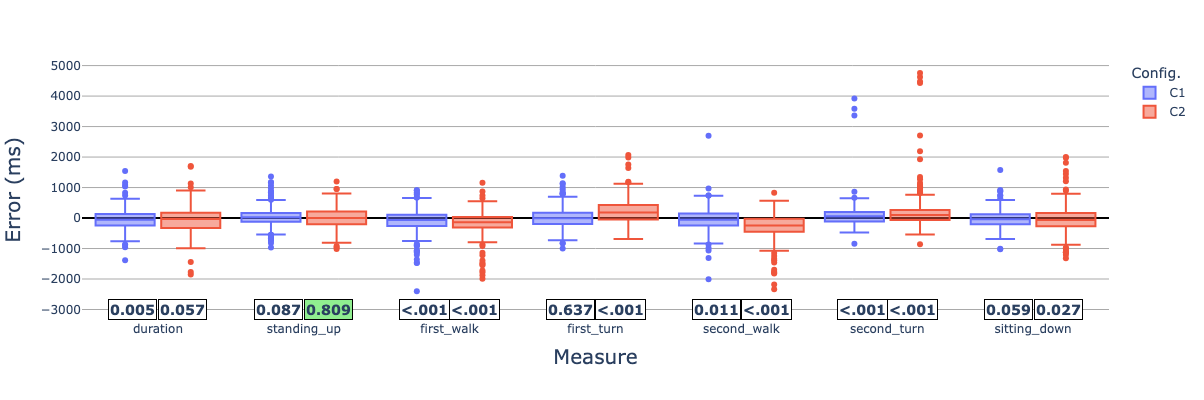

In [6]:
#| label: fig-error_distribution 
#| fig-cap: "Measurements error's distribution for the total duration and each subphase for **success** executions in `C1` and `C2`. At the bottom are the *p-values* of the one-sample T-test (green) or W-test (white) comparing the means of each distribution with $0$, where a p-value > $0.05$ indicates no significant differences between the distribution mean and $0$." 
#| column: page-inset-right

error_distribution(errors_df)


@tbl-rmse_comparison shows the inter-subject RMSE and the results of the statistical tests executed comparing each measure in both systems. `C1` reported significantly better results in the *duration*, *first_turn* and *sitting_down* measures. Other not significant differences were observed in *standing_up* and *second_walk* in favour of `C1`, and in *first_walk* and *second_turn* in favour of `C2`. These results denote that the system performs better in `C1` than in `C2` when taking into account different subjects (i.e., `C1` is more adaptable to different subjects).

In [7]:
#| label: tbl-rmse_comparison
#| tbl-cap: "Comparison of the inter-subject RMSE of each measurement for both system configurations."

compare_rmse_distributions(errors_df)

Measure       M(C1)       M(C2)  \
0      duration  287.000000  389.000000   
1   standing_up  286.766667  336.821429   
2    first_walk  296.000000  268.500000   
3    first_turn  278.500000  356.000000   
4   second_walk  291.000000  338.000000   
5   second_turn  233.000000  217.000000   
6  sitting_down  269.500000  322.500000   

                                                Test  
0                  U=280.5, p-val=0.031, power=0.542  
1  t(55.90)=-1.24, p-val=0.222, power=0.227200896...  
2                  U=460.5, p-val=0.534, power=0.338  
3                  U=285.5, p-val=0.037, power=0.434  
4                  U=326.0, p-val=0.146, power=0.283  
5                  U=410.5, p-val=0.889, power=0.197  
6                   U=280.0, p-val=0.03, power=0.603

### Bland-Altman analysis

To determine the agreement between each system configuration and the reference measures, @fig-ba_duration and @fig-ba_subphases show the Bland-Altman agreement analysis for the *duration* and the rest of the measures, respectively. For the *duration* measurement, `C1` and `C2` show an excellent mean of $-0.044$ and $-0.051$ with $95\%$ agreement limits of $[-0.7,0.61]$ and $[-0.91,0.8]$. These results indicate a low bias with regards to the reference method and that $5\%$ of the measurements exceed an error of $0.7$ seconds in `C1` and $0.9$ in `C2`. 

Regarding the measures of the TUG subphases, `C1` shows slightly better means (all under $0.1$ seconds) than `C2` in all subphases except for the *standing_up*. The limits of agreement in `C1` are around $0.6-0.9$ and in `C2` exceed the second. `C1` results indicate a low bias with respect to reference measures, while `C2` shows biases of around $0.2$ seconds for walking and turning activities, which are underestimated and overestimated, respectively.

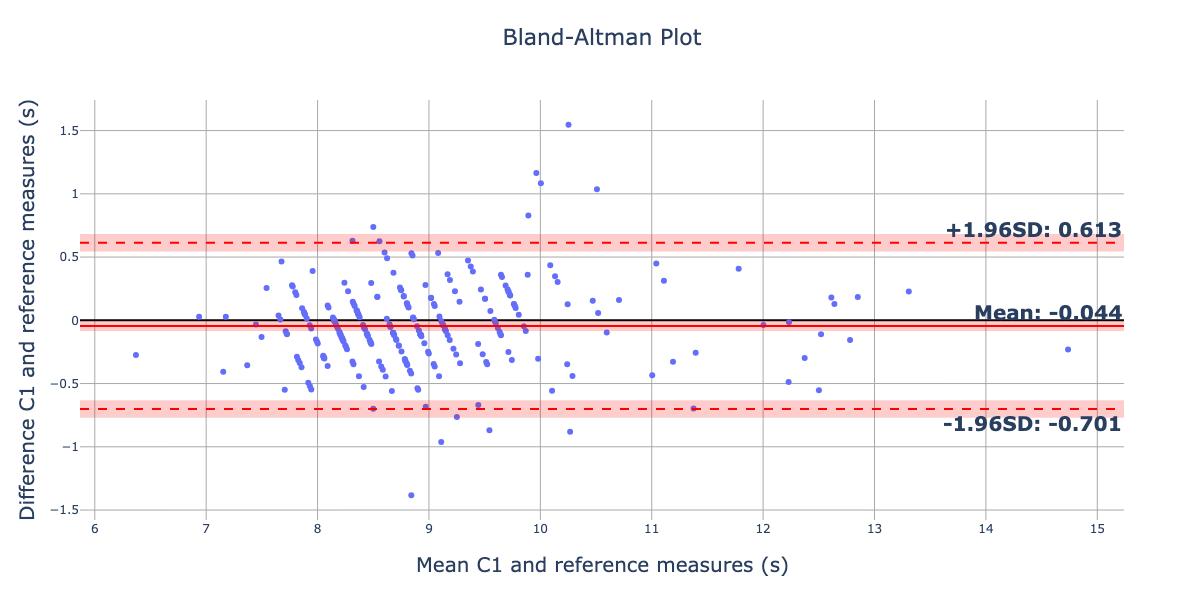

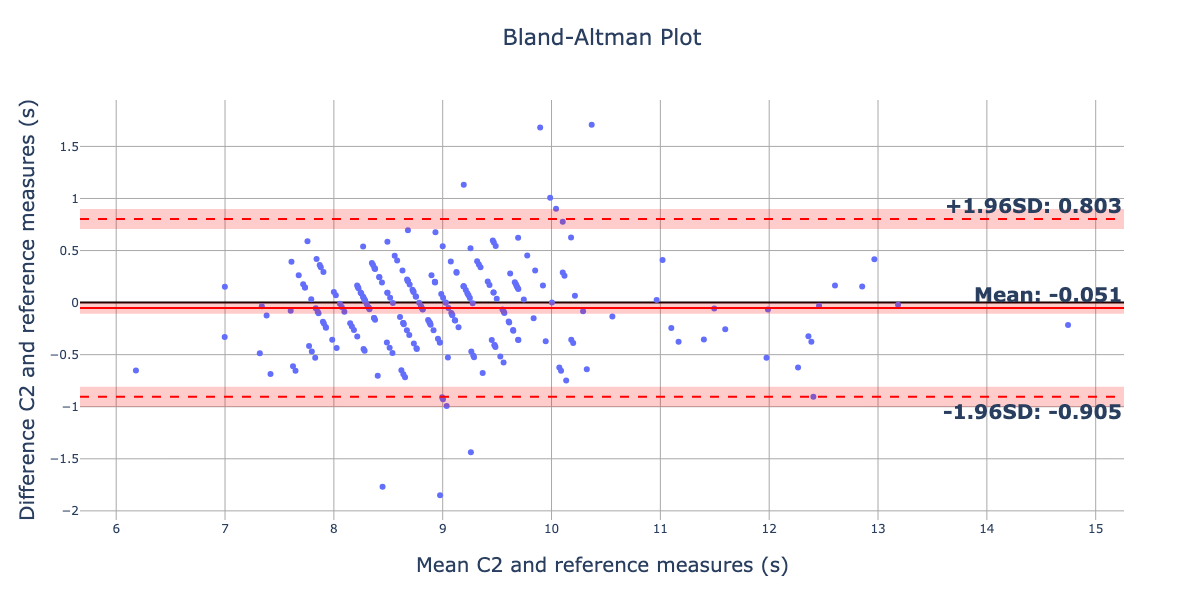

In [8]:
#| label: fig-ba_duration
#| fig-cap: "Blant-Altman analysis of the total duration of the test computed by the system in both configurations. The red line represents the mean difference and both dotted lines are the limits of agreement (with $95$% CI)."
#| fig-subcap:
#|   - "`C1` configuration"
#|   - "`C2` configuration"
#| layout-ncol: 1

bland_altman_plot(c1_results, man_results, 'C1', ['duration'], with_titles=False).show()
bland_altman_plot(c2_results, man_results, 'C2', ['duration'], with_titles=False).show()

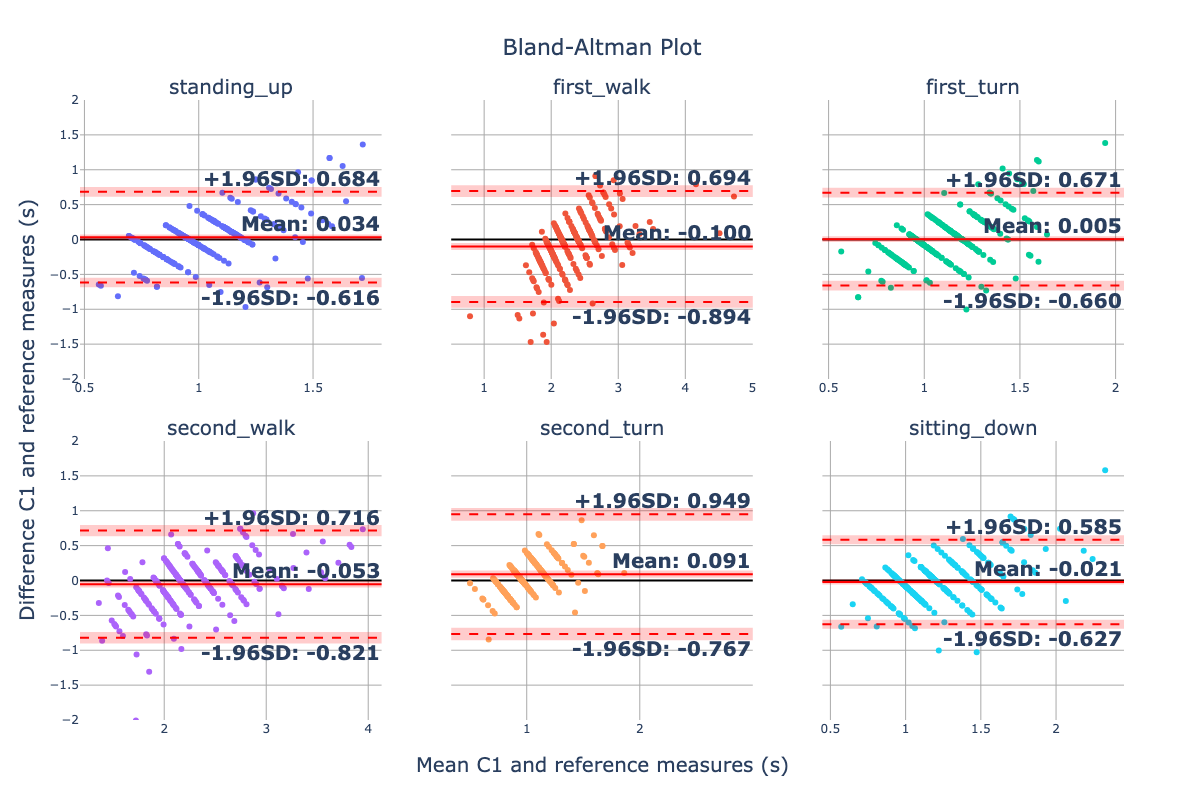

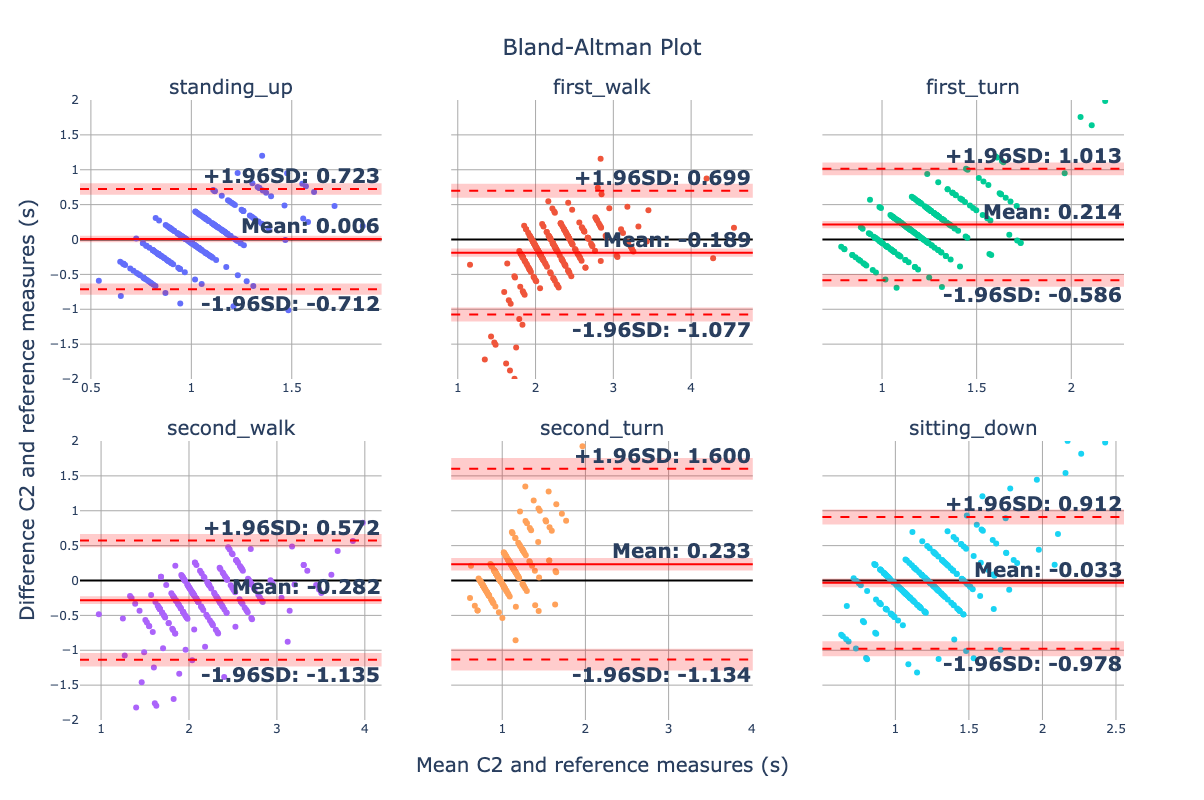

In [9]:
#| label: fig-ba_subphases
#| fig-cap: "Blant-Altman analysis of the TUG subphases of the test computed by the system in both configurations. The red line represents the mean difference and both dotted lines are the limits of agreement (with $95$% CI)."
#| fig-subcap:
#|   - "`C1` configuration"
#|   - "`C2` configuration"
#| layout-ncol: 1
#| column: page-inset-right

bland_altman_plot(c1_results, man_results, 'C1', PHASES, limit_y_axis_to=[-2, 2]).show()
bland_altman_plot(c2_results, man_results, 'C2', PHASES, limit_y_axis_to=[-2, 2]).show()

### Intraclass Correlation Coefficent (ICC) analysis

To measure the reliability of both configurations, @tbl-icc contains the ICC estimates and their $95\%$ confident intervals based on a single rater, absolute-agreement, 2-way mixed-effects model comparing the measures obtained by both system configurations with the reference ones. ICC results show excellent reliability for the *duration* in both system configurations. 
Regarding the subphases, `C1` achieves excellent reliability in the *second_walk*; good reliability in *first_walk*; moderate reliability in *second_turn* and *sitting_down*, and poor reliability for the remaining ones, whereby the reliability of the *first_turn* is non-significant (i.e., CI contains 0). `C2` achieves moderate reliability in *first_walk* and *second_walk* while obtaining poor reliability in the rest, with non-significant results for *standing_up*, *first_turn* and *second_turn*.

In [10]:
#| label: tbl-icc
#| tbl-cap: "Intraclass correlation from single rater, absolute-agreement, 2-way mixed-effects model between system's configurations measurements and the reference (manual) measurements."

compute_icc([c1_results, c2_results], man_results, ['C1', 'C2'], icc_type='ICC2')

ICC             CI  F Test  p-value
phase        system                                       
duration     C1      0.979   [0.96, 0.99]  94.521    0.000
             C2      0.972   [0.94, 0.99]  72.498    0.000
standing_up  C1      0.456    [0.12, 0.7]   2.677    0.005
             C2      0.176  [-0.22, 0.52]   1.414    0.187
first_walk   C1      0.822   [0.63, 0.91]  11.755    0.000
             C2      0.687   [0.32, 0.86]   7.076    0.000
first_turn   C1      0.264  [-0.11, 0.57]   1.694    0.081
             C2      0.026   [-0.19, 0.3]   1.085    0.417
second_walk  C1      0.916   [0.83, 0.96]  24.004    0.000
             C2      0.627    [0.1, 0.84]   6.922    0.000
second_turn  C1      0.540    [0.2, 0.76]   3.987    0.000
             C2      0.107  [-0.19, 0.42]   1.298    0.251
sitting_down C1      0.697   [0.45, 0.84]   5.471    0.000
             C2      0.454     [0.1, 0.7]   2.634    0.007

## Summary

These results (errors, Bland-Altman and ICC analyses) show that while the system is reliable in terms of measuring the total duration of the test, measurements of individual subphases must be considered carefully, especially when using the system with configuration `C2`. This is probably caused by the underestimation of some subphases while overestimating others, leading to a reliable total duration but less reliable subphases' durations. 

When comparing `C1` and `C2` configurations, the presented results provide evidence that the smartwatch-based system performs better than the smartphone-based system, both for the overall test duration and for the individual subphases detection.

Overall, the developed system, using off-the-shelf hardware (i.e., smartphone and smartwatch), presented state-of-the-art results in the computation of the TUG test duration, even when compared with systems using specialized sensor units and/or positioning sensing devices in unnatural positions (e.g., strapped to the arms or legs). This paves the way to real-life applicability (e.g., self-administration) of the TUG test and other similar tests. On the other hand, the computed duration of the TUG subphases must be considered carefully, especially in the `C2` configuration, which is penalized given the diversity of front pockets and phone orientations.

## Code reference

::: {.callout-tip}
The documentation of the Python functions employed in this section can be found in
 [Chapter 4 reference](reference/index.qmd#chapter-4):

- [`data_loading`](reference/chapter4.analysis.data_loading.qmd):
  - [`load_subjects_info`](reference/chapter4.analysis.data_loading.qmd#libs.chapter4.analysis.data_loading.load_subjects_info)
  - [`load_experiment_results`](reference/chapter4.analysis.data_loading.qmd#libs.chapter4.analysis.data_loading.load_experiment_results)
- [`statistical_tests`](reference/chapter4.analysis.statistical_tests.qmd):
  - [`compare_rmse_distributions`](reference/chapter4.analysis.statistical_tests.qmd#libs.chapter4.analysis.statistical_tests.compare_rmse_distributions)
  - [`compute_icc`](reference/chapter4.analysis.statistical_tests.qmd#libs.chapter4.analysis.statistical_tests.compute_icc)
- [`tug_results_processing`](reference/chapter4.analysis.tug_results_processing.qmd):
  - [`check_status`](reference/chapter4.analysis.tug_results_processing.qmd#libs.chapter4.analysis.tug_results_processing.check_status)
  - [`compute_errors_by_subject`](reference/chapter4.analysis.tug_results_processing.qmd#libs.chapter4.analysis.tug_results_processing.compute_errors_by_subject)
  - [`invalidate_executions`](reference/chapter4.analysis.tug_results_processing.qmd#libs.chapter4.analysis.tug_results_processing.invalidate_executions)
- [`visualization`](reference/chapter4.analysis.visualization.qmd):
  - [`error_distribution`](reference/chapter4.analysis.visualization.qmd#libs.chapter4.analysis.visualization.error_distribution)
  - [`bland_altman_plot`](reference/chapter4.analysis.visualization.qmd#libs.chapter4.analysis.visualization.bland_altman_plot)
:::